In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  import os
  CWD = '/content/drive/MyDrive/DataSources/SkinCare'
  os.chdir(CWD)
except:None
G_path = './Project_Data'

In [2]:
import numpy as np
import os
import torch
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import time

from statistics import mean
import sklearn as sk
import warnings
from sklearn.utils import resample
import pickle as pickle
import PIL as pl
import pandas as pd
from PIL.Image import Transpose
from PIL import Image
warnings.filterwarnings('ignore')
import features
from features.usefull_functions import *
from features.NETs import *
from features.Model_Training import *

# **Import Augmented Images and rescaling**

In [4]:
Augment_Path = G_path + '/' + '01_Augmented_Imaged'
Rescaled_Images = G_path + '/04_Rescaled_Images/60x45'

In [5]:
img_list = []
for path, dirs, files in  os.walk(Augment_Path):
    for f in files:
        img_list.append( path +'/' + f)
    for d in dirs:
        img_list.append( path + d)
img_list = list(set([x for x in img_list if ".jpg" in x] ))

try:
    os.makedirs(Rescaled_Images)
except:
    None

for img in tqdm(img_list):
    file_out = Rescaled_Images +'/'+ re.findall('\w+',img)[-2:-1][0] +'.jpg'
    os.system('convert %s %s %s' % ('-resize 10%',img,file_out))

100%|██████████| 5807/5807 [01:41<00:00, 57.22it/s]


# **Import Rescaled Images and convert to arrays**

In [6]:
img_list = os.listdir(Rescaled_Images)
Augmented_dataset = pd.DataFrame(columns=['image_id','img_array'])
for img in tqdm(img_list):
    if '.jpg' in img:
        img_name = img.replace('.jpg','')
        image = pl.Image.open( Rescaled_Images +'/'+ img)
        img_array = np.asarray(image)
        new_row = pd.Series({'image_id':img_name,'img_array':img_array}, name='')
        Augmented_dataset = Augmented_dataset.append(new_row)

100%|██████████| 5808/5808 [00:05<00:00, 1135.77it/s]


In [7]:
Meta_Data_Augmented = pickle.load(open(G_path + '/02_Augmented_MetaData/'+ '/Meta_Data_Augmented','rb'))
blc_test_meta = pickle.load(open(G_path + '/02_Augmented_MetaData/'+ '/balanced_test_set','rb'))

CNN_rescaled_dataset = Augmented_dataset.merge(Meta_Data_Augmented, how="left",on='image_id')
blc_test_dataset_rescaled = Augmented_dataset[['image_id','img_array']].merge(blc_test_meta, how="right",on='image_id')

# **CNN_Rescaled: Standardization**

In [8]:
df_ = CNN_rescaled_dataset
train_data = df_[df_.type=='train']
valid_data = df_[df_.type=='valid']
test_data = df_[df_.type=='test']
print('Train size: ',train_data.shape[0] ,' Valid Size: ',valid_data.shape[0], ' Test size: ', test_data.shape[0])

Train size:  4993  Valid Size:  407  Test size:  407


In [9]:
training_data = pd.concat([train_data,valid_data], axis=0)
training_arrays_scaled = np.stack(training_data['img_array'].values)  / 255
Mean = training_arrays_scaled.mean(axis = (0,1,2)) 
STD = training_arrays_scaled.std(axis = (0,1,2))
print(f"Mean : {Mean}   STD: {STD}") 

Mean : [0.76777839 0.56153362 0.58670107]   STD: [0.13027405 0.14324789 0.15677792]


In [10]:
#Train data standardization
train_arrays_std = np.stack(train_data['img_array'].values) / 255
for i in range(0,train_arrays_std.shape[0]):
    train_arrays_std[i] = (train_arrays_std[i] - Mean) / STD
#Validation data standardization
valid_arrays_std = np.stack(valid_data['img_array'].values) / 255

for i in range(0,valid_arrays_std.shape[0]):
    valid_arrays_std[i] = (valid_arrays_std[i] - Mean) / STD
#Test data standardization
test_arrays_std = np.stack(test_data['img_array'].values) / 255
for i in range(0,test_arrays_std.shape[0]):
    test_arrays_std[i] = (test_arrays_std[i] - Mean) / STD

#Test-Valid data standardization
test_valid_arrays_std = np.stack(blc_test_dataset_rescaled['img_array'].values) / 255
for i in range(0,test_valid_arrays_std.shape[0]):
    test_valid_arrays_std[i] = (test_valid_arrays_std[i] - Mean) / STD

In [11]:
Mean_t = test_arrays_std.mean(axis = (0,1,2)) 
STD_t = test_arrays_std.std(axis = (0,1,2))
print(f"Test Set Mean : {Mean_t}   Test Set STD: {STD_t}") 

Test Set Mean : [-0.03498445 -0.10848925 -0.11333694]   Test Set STD: [0.99691203 1.02121079 1.03583508]


In [12]:
metda_keys = train_data[['type','image_id']].reset_index(drop=True), valid_data[['type','image_id']].reset_index(drop=True), test_data[['type','image_id']].reset_index(drop=True)

train_arrays_std_T = torch.tensor(train_arrays_std, dtype= torch.float32).transpose(3,1)
train_labels = torch.tensor(train_data['image_label'].values.astype(np.long))

valid_arrays_std_T = torch.tensor(valid_arrays_std, dtype= torch.float32).transpose(3,1)
valid_labels = torch.tensor(valid_data['image_label'].values.astype(np.long))

test_arrays_std_T = torch.tensor(test_arrays_std, dtype= torch.float32).transpose(3,1)
test_labels = torch.tensor(test_data['image_label'].values.astype(np.long))

test_valid_arrays_std_T = torch.tensor(test_valid_arrays_std, dtype= torch.float32).transpose(3,1)
test_valid_labels = torch.tensor(blc_test_dataset_rescaled['image_label'].values.astype(np.long))

train_labels_binary =  torch.tensor(label_to_binary(train_labels))
valid_labels_binary =  torch.tensor(label_to_binary(valid_labels))
test_labels_binary =  torch.tensor(label_to_binary(test_labels))
test_valid_labels_binary =  torch.tensor(label_to_binary(test_valid_labels))


input_data = (train_arrays_std_T , valid_arrays_std_T, test_arrays_std_T ,metda_keys)
labels = ((train_labels,valid_labels,test_labels), (train_labels_binary , valid_labels_binary ,test_labels_binary))

balc_evaluation_set = (test_valid_arrays_std_T,test_valid_labels,test_valid_labels_binary)

In [ ]:
dataset_training = G_path + '/06_Rescaled_DataSet'

try:
    os.makedirs(dataset_training)
except:
    None

pickle.dump((input_data,labels), open(dataset_training + '/Input_DataSet_60x45', 'wb'))
pickle.dump(balc_evaluation_set, open(dataset_training + '/Balanced_Test_Set_60x45', 'wb'))

# **Import AutoEncoders Images**

In [12]:
def import_imges(img_path):
    img_list = []
    for path, dirs, files in  os.walk(img_path):
        for f in files:
            img_list.append( path +'/' + f)
        for d in dirs:
            img_list.append( path + d)
    img_list = list(set([x for x in img_list if ".jpg" in x] ))

    dataset = pd.DataFrame(columns=['image_id','img_array'])
    for img in tqdm(img_list):
        img_name = re.findall('\w+', img)[-2:-1][0]
        image = pl.Image.open( img)
        img_array = np.asarray(image)
        new_row = pd.Series({'image_id':img_name,'img_array':img_array}, name='')
        dataset = dataset.append(new_row)
    return dataset

train_path = G_path + '/Augmented_AutoEncoded/train'
valid_path = G_path + '/Augmented_AutoEncoded/valid'
test_path = G_path + '/Augmented_AutoEncoded/test'

train_set = import_imges(train_path)
valid_set = import_imges(valid_path)
test_set = import_imges(test_path)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [13]:
dataset_ = pd.concat([train_set,valid_set,test_set],axis=0)
A_E_dataset = dataset_.merge(Meta_Data_Augmented, how='left', on='image_id')
blc_test_dataset_A_E = dataset_[['image_id','img_array']].merge(blc_test_meta, how="right",on='image_id')

In [14]:
df_ = A_E_dataset
train_data = df_[df_.type=='train']
valid_data = df_[df_.type=='valid']
test_data = df_[df_.type=='test']
print('Train size: ',train_data.shape[0] ,' Valid Size: ',valid_data.shape[0], ' Test size: ', test_data.shape[0])

Train size:  0  Valid Size:  0  Test size:  0


In [16]:
training_data = pd.concat([train_data,valid_data], axis=0)
training_arrays_scaled = np.stack(training_data['img_array'].values)  / 255
Mean = training_arrays_scaled.mean(axis = (0,1,2)) 
STD = training_arrays_scaled.std(axis = (0,1,2))
print(f"Mean : {Mean}   STD: {STD}") 

ValueError: need at least one array to stack

In [ ]:
#Train data standardization
train_arrays_std = np.stack(train_data['img_array'].values) / 255
for i in range(0,train_arrays_std.shape[0]):
    train_arrays_std[i] = (train_arrays_std[i] - Mean) / STD
#Validation data standardization
valid_arrays_std = np.stack(valid_data['img_array'].values) / 255
for i in range(0,valid_arrays_std.shape[0]):
    valid_arrays_std[i] = (valid_arrays_std[i] - Mean) / STD
#Test data standardization
test_arrays_std = np.stack(test_data['img_array'].values) / 255
for i in range(0,test_arrays_std.shape[0]):
    test_arrays_std[i] = (test_arrays_std[i] - Mean) / STD

#Test-Valid data standardization
test_valid_arrays_std = np.stack(blc_test_dataset_A_E['img_array'].values) / 255
for i in range(0,test_valid_arrays_std.shape[0]):
    test_valid_arrays_std[i] = (test_valid_arrays_std[i] - Mean) / STD

In [ ]:
Mean_t = test_arrays_std.mean(axis = (0,1,2)) 
STD_t = test_arrays_std.std(axis = (0,1,2))
print(f"Test Set Mean : {Mean_t}   Test Set STD: {STD_t}") 

Test Set Mean : [-0.04389305 -0.05144053  0.03501551]   Test Set STD: [0.93557654 0.98728975 1.00074642]


In [ ]:
metda_keys = train_data[['type','image_id']].reset_index(drop=True), valid_data[['type','image_id']].reset_index(drop=True), test_data[['type','image_id']].reset_index(drop=True)

In [ ]:
train_arrays_std_T = torch.tensor(train_arrays_std, dtype= torch.float32).transpose(3,1)
train_labels = torch.tensor(train_data['image_label'].values.astype(np.long))

valid_arrays_std_T = torch.tensor(valid_arrays_std, dtype= torch.float32).transpose(3,1)
valid_labels = torch.tensor(valid_data['image_label'].values.astype(np.long))

test_arrays_std_T = torch.tensor(test_arrays_std, dtype= torch.float32).transpose(3,1)
test_labels = torch.tensor(test_data['image_label'].values.astype(np.long))

test_valid_arrays_std_T = torch.tensor(test_valid_arrays_std, dtype= torch.float32).transpose(3,1)
test_valid_labels = torch.tensor(blc_test_dataset_A_E['image_label'].values.astype(np.long))

A_E_input_data = (train_arrays_std_T , valid_arrays_std_T, test_arrays_std_T ,metda_keys)

train_labels_binary =  torch.tensor(label_to_binary(train_labels))
valid_labels_binary =  torch.tensor(label_to_binary(valid_labels))
test_labels_binary =  torch.tensor(label_to_binary(test_labels))

A_E_labels = ((train_labels,valid_labels,test_labels), (train_labels_binary , valid_labels_binary ,test_labels_binary))

A_E_balc_test_set = (test_valid_arrays_std_T,test_valid_labels)

In [ ]:
pickle.dump((A_E_input_data,A_E_labels), open(G_path + '/Augmented_AutoEncoded/'+ 'Latent_Input_Data_labels', 'wb'))
pickle.dump(A_E_balc_test_set, open(G_path +  '/Augmented_AutoEncoded/'+  '/Evaluation_set_AutoEncoder', 'wb'))

In [9]:
CNN_280x210_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4647 entries, 0 to 4646
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   image_id      4647 non-null   object  
 1   img_array     4647 non-null   object  
 2   lesion_id     4647 non-null   object  
 3   dx            4647 non-null   category
 4   dx_type       4647 non-null   object  
 5   age           4647 non-null   float64 
 6   sex           4647 non-null   object  
 7   localization  4647 non-null   object  
 8   image_label   4647 non-null   int8    
 9   binary_label  4647 non-null   int64   
 10  type          4647 non-null   object  
dtypes: category(1), float64(1), int64(1), int8(1), object(7)
memory usage: 372.2+ KB


In [85]:
np.random.choice(df_.shape[0], 1, replace=False)[0]

4639

In [172]:
train_std_df = pd.DataFrame(columns = ['img_array_std'])
for i in range(train_arrays_std.shape[0]):
    new_row = pd.Series({'img_array_std':train_arrays_std[i]}, name='')
    train_std_df = train_std_df.append(new_row)

In [173]:
train_df_x_img = pd.concat([train_data.reset_index(drop=True),train_std_df.reset_index(drop=True)],axis=1)

In [174]:
train_data.shape, train_std_df.shape, train_df_x_img.shape

((3833, 12), (3833, 1), (3833, 13))

In [193]:
df_

,image_id,img_array,lesion_id,dx,dx_type,age,sex,localization,label_description,image_label,binary_label,type,img_array_std
0,ISIC_0032929,"[[[124, 95, 115], [124, 94, 106], [118, 92, 10...",HAM_0003321,bkl,histo,75.0,female,face,keratosis-like,2,0,train,"[[[-2.052070992316246, -1.2130273548047215, -0..."
1,ISIC_0026790,"[[[254, 217, 225], [252, 216, 220], [254, 217,...",HAM_0005779,bkl,consensus,55.0,male,back,keratosis-like,2,0,train,"[[[1.6918385713583919, 2.0165860201592074, 1.8..."
2,ISIC_0025299,"[[[191, 152, 157], [193, 152, 158], [193, 152,...",HAM_0007313,bcc,histo,70.0,male,back,basal cell carcinoma,1,1,train,"[[[-0.12251760180700953, 0.29589036956367154, ..."
3,AUG_ISIC_0027297,"[[[241, 203, 202], [240, 202, 201], [240, 202,...",HAM_0003186,bcc,histo,70.0,male,face,basal cell carcinoma,1,1,train,"[[[1.3174476149909278, 1.6459746492617071, 1.3..."
4,ISIC_0032915,"[[[118, 83, 90], [120, 86, 87], [122, 87, 85],...",HAM_0001524,mel,histo,75.0,male,lower extremity,melanoma,4,1,train,"[[[-2.224866818331998, -1.5306942441454356, -1..."
5,ISIC_0030870,"[[[218, 167, 164], [214, 163, 160], [216, 166,...",HAM_0006707,df,consensus,45.0,female,lower extremity,dermatofibroma,3,0,train,"[[[0.6550636152638765, 0.6929739812395646, 0.4..."
6,ISIC_0024805,"[[[206, 181, 185], [209, 178, 184], [207, 177,...",HAM_0005724,mel,histo,75.0,male,upper extremity,melanoma,4,1,train,"[[[0.30947196323237186, 1.0635853521370648, 0...."
7,ISIC_0025528,"[[[199, 101, 92], [197, 104, 89], [202, 106, 9...",HAM_0005597,nv,follow_up,45.0,female,trunk,melanocytic nevi,5,0,train,"[[[0.10787683288066048, -1.0541939101343645, -..."
8,ISIC_0030643,"[[[216, 148, 173], [218, 148, 174], [222, 148,...",HAM_0004894,nv,follow_up,50.0,male,trunk,melanocytic nevi,5,0,train,"[[[0.5974650065919591, 0.1900014064501005, 0.6..."
11,AUG_ISIC_0030714,"[[[135, 97, 96], [136, 98, 97], [137, 99, 98],...",HAM_0003989,akiec,histo,70.0,female,face,Actinic keratoses,0,1,train,"[[[-1.7352786446206996, -1.1600828732479358, -..."


In [203]:
for p in range(1,rows*columns//2 +1):
  i = np.random.choice(df_.shape[0], 1, replace=False)[0]


import random
rand_list = random.sample(range(0, df_.shape[0]), rows*columns//2)
rand_list[0]

9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


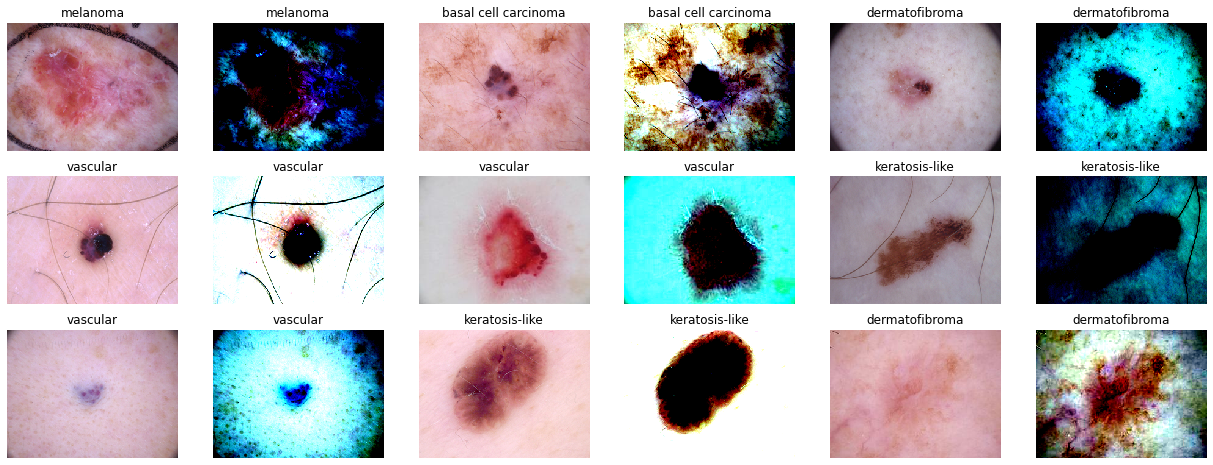

In [209]:
df_ = train_df_x_img.groupby('image_label').head(3)
# df_ = train_arrays_std.groupby('image_label').head(30)
fig = plt.figure(figsize=(21.5,8))
# fig2 = plt.figure(figsize=(18,12))
rows = 3
columns = 6

rand_list = random.sample(range(0, df_.shape[0]), rows*columns//2)
# fig, axs = plt.subplots(1,2,figsize=(14,4))
for p in range(0,rows*columns//2):
  
  i = rand_list[p]
  image1 = torch.from_numpy(df_['img_array'].iloc[i])
  image2 = torch.from_numpy(df_['img_array_std'].iloc[i])
  # image1 = torch.from_numpy(train_arrays_std[i])
  fig.add_subplot(rows, columns, 2*p+1).set_title( df_['label_description'].iloc[i])
  plt.imshow(image1, interpolation='nearest')
  plt.axis('off')
  fig.add_subplot(rows, columns, 2*p+2).set_title( df_['label_description'].iloc[i])
  plt.imshow(image2, interpolation='nearest')
  plt.axis('off')
  plt.title( df_['label_description'].iloc[i])
  # plt.show()

<Figure size 432x288 with 0 Axes>

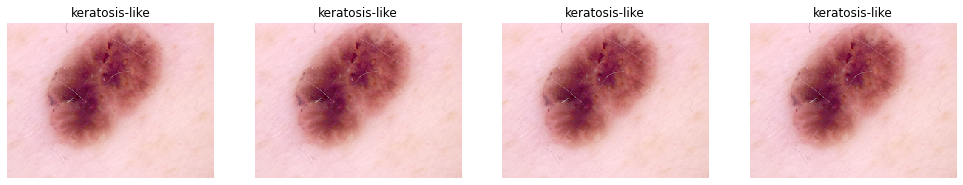

In [64]:
df_ = CNN_280x210_dataset

fig = plt.figure()
rows = 1
columns = 4

# fig, axs = plt.subplots(rows,columns,figsize=(17,10))
i=1

image1 = torch.from_numpy(df_['img_array'].iloc[i])

for ax,_ in zip(axs,[1,2,3,4]):
# fig.add_subplot(rows, columns, i)
    ax.imshow(image1, interpolation='nearest')
    ax.axis('off')
    ax.set_title( df_['label_description'].iloc[i])



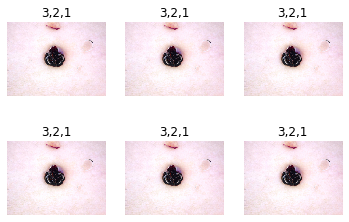

In [82]:
#define figure
fig = plt.figure()
i = 1
#add subplots
rows = 2
columns = 3
for i in range(1,7):
    fig.add_subplot(rows,columns,i).set_title('3,2,1')
    plt.imshow(image1, interpolation='nearest')
    plt.axis('off')
    #display plots
plt.show()